# Polymers

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

In [14]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist

In [2]:
# 1b)Petar lukter

def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.

In [3]:
def createDirectionList(polymerPart):
    dir = np.zeros(len(polymerPart-1))
    for i in range(len(polymerPart)-1):
        d = polymerPart[i+1] - polymerPart[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


In [4]:
def rotatePolymer(p, coord, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    rotatingBase = -1
    polymer = np.copy(p)
    N = len(polymer)
    # finds index of monomer to rotate around
    for i in range(len(polymer)):
        if np.array_equal(polymer[i],coord):
            rotatingBase = i
            break
    rotatingLeft = rotatingBase <= len(polymer)//2

    directionList = createDirectionList(polymer)
    if rotatingLeft:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4

    #IDEA: Calculate direction change for every polymer to be rotated. Then use this info to recalculate the position based of the rotation base.
    #print(directionList)

    if rotatingLeft:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, len(polymer)):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

1d)

In [5]:
def visualize_polymer(polymer):
    # Calculate the minimum and maximum coordinates of the polymer
    min_x = int(np.min(polymer[:, 0]))
    max_x = int(np.max(polymer[:, 0]))
    min_y = int(np.min(polymer[:, 1]))
    max_y = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    grid_width = max_x - min_x + 1
    grid_height = max_y - min_y + 1
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((grid_height, grid_width))

    # Plot the polymer on the grid
    for i, (x, y) in enumerate(polymer):
        grid[int(y - min_y), int(x - min_x)] = i + 1

    # Visualize the grid
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

In [6]:
# 1e)

def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    
    #Finner lengden av polymeret
    length = len(polymer)

    # Hvis lengden av monomeret er kortere enn n har vi "mistet" et monomer
    if length != N:
        return False

    #Finner lengden av uni_length som fjerner eventuelle duplikater i polymeret
    uni_length = len(np.unique(polymer, axis=0)) 

    if uni_length != length:
        return False

    #Sjekker om avstanden mellom hvert av monomerene er 1
    for i in range(N-1): 
        x_dist = np.abs(polymer[i+1][0]-polymer[i][0])
        y_dist = np.abs(polymer[i+1][1]-polymer[i][1])
        distance = x_dist + y_dist
        if distance != 1 or length != N or uni_length != length:

            #Returnerer false dersom set_length er ulik length (duplikat-verdi i polymeret),
            #length ulik n, eller monomerer er lenger enn 1 i avstand unna hverandre
            return False
    return True

In [33]:
# 1j)


def calculateEnergy(polymer, V):
    b = cdist(polymer, polymer, 'cityblock') == 1
    energyMatrix = np.multiply(V,b)
    return np.sum(energyMatrix)/2

V = np.zeros([len(t1),len(t1)])
V[np.tril_indices_from(V,-2)] = -1
V[np.triu_indices_from(V,2)] = -1

print(calculateEnergy(t1,V))
    

-24.0


246


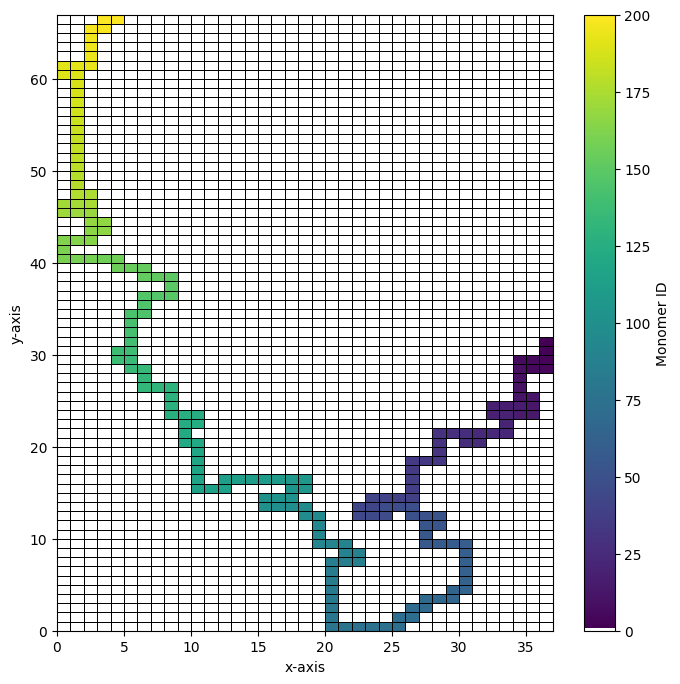

In [8]:
# 1g
# Calculate the minimum and maximum coordinates of the polymer
def testRotate(N, N_s):
    polymer = createPolymer(N)
    twisted_polymer = np.array([])
    succesRotations = 0

    for i in range(N_s):
        rotateMonomer = np.random.randint(1, N+1)
        rotateMonomer = polymer[rotateMonomer - 1]
        rotateDirection = np.random.randint(1,3)
        if rotateDirection == 1:
            twisted_polymer = rotatePolymer(polymer, rotateMonomer, clockwise = True)
            if isIntact(twisted_polymer, N) == True:
                succesRotations += 1 
                polymer = np.copy(twisted_polymer)
        if rotateDirection == 2:
             twisted_polymer = rotatePolymer(polymer, rotateMonomer, clockwise = False)
             if isIntact(twisted_polymer, N) == True:
                succesRotations += 1 
                polymer = np.copy(twisted_polymer)
        # visualize_polymer(polymer)

    
    return polymer, succesRotations

t = testRotate(200, 500)
t1 = t[0]
t2 = t[1]
print(t2)
visualize_polymer(t1)


In [ ]:
#2a)

def metropolis(polymer, N_s, V, T):
    E_arr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    i = 1
    while i < N_s:
        xRand = np.random.random_integers(0, len(polymer)-1)
        twist_coords = polymer[xRand]
        clockwise = bool(np.random.random_integers(0,1))
        twisted_polymer = np.copy(polymer)
        twisted_polymer = rotatePolymer(twisted_polymer,twist_coords, clockwise)
        if isIntact(twisted_polymer):
            i += 1
            E_new = calculateEnergy(twisted_polymer, V)
            if E_new > E or np.random.uniform() < np.exp(-beta*(E_new - E)):
                polymer = np.copy(twisted_polymer)
                E = E_new
            E_arr[i] = E
    return polymer, E_arr
            
